In [1]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import mlflow
import mlflow.sklearn
import os
import warnings
import json
import dagshub
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_all_run_ids(experiment_name: str) -> pd.DataFrame:
    """
    Retrieves a DataFrame of all runs in a specific MLflow experiment.

    Args:
        experiment_name (str): The name of the MLflow experiment.

    Returns:
        pd.DataFrame: A DataFrame containing run information.
    """
    try:
        experiment = mlflow.get_experiment_by_name(experiment_name)
        if experiment is None:
            raise ValueError(f"Experiment '{experiment_name}' not found.")
        
        # KEY CHANGE: Filter for runs that have a parentRunId tag
        runs = mlflow.search_runs(
            experiment_ids=[experiment.experiment_id])
        runs = runs[~runs['tags.mlflow.parentRunId'].isna()]
        return runs

    # try:
    #     experiment = mlflow.get_experiment_by_name(experiment_name)
    #     if experiment is None:
    #         raise ValueError(f"Experiment '{experiment_name}' not found.")
        
    #     runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

    #     return runs
    except Exception as e:
        print(f"Error fetching MLflow runs: {e}")
        return pd.DataFrame()


In [3]:
dagshub_url = "https://dagshub.com"
repo_owner = 'anshu57'
repo_name = 'telecom-customer-churn-prediction'
dagshub.init(repo_owner='anshu57', repo_name='telecom-customer-churn-prediction', mlflow=True)
mlflow.set_tracking_uri(f"{dagshub_url}/{repo_owner}/{repo_name}.mlflow")

Accessing as anshu57

Initialized MLflow to track repo "anshu57/telecom-customer-churn-prediction"

Repository anshu57/telecom-customer-churn-prediction initialized!

In [ ]:
def evaluate_and_register_best_model(test_data_path: str, experiment_name: str):
    """
    Loads test data, evaluates all models from MLflow runs, logs metrics for each,
    and registers the single best model.

    Args:
        test_data_path (str): The file path to the processed test data.
        experiment_name (str): The name of the MLflow experiment to evaluate.
    """
    warnings.filterwarnings('ignore')
    
    # # DagsHub repository details
    # dagshub_token = os.getenv("DAGSHUB_TOKEN")
    # if not dagshub_token:
    #     raise EnvironmentError("DAGSHUB_TOKEN env variable is not set")


    # os.environ["MLFLOW_TRACKING_USERNAME"] = dagshub_token
    # os.environ["MLFLOW_TRACKING_PASSWORD"] = dagshub_token
    
    dagshub_url = "https://dagshub.com"
    repo_owner = 'anshu57'
    repo_name = 'telecom-customer-churn-prediction'
    dagshub.init(repo_owner='anshu57', repo_name='telecom-customer-churn-prediction', mlflow=True)
    mlflow.set_tracking_uri(f"{dagshub_url}/{repo_owner}/{repo_name}.mlflow")

    # Load the processed test data
    try:
        test_df = pd.read_csv(test_data_path)
    except FileNotFoundError as e:
        print(f"Error: {e}. Please ensure '{test_data_path}' exists.")
        return

    # Separate features and target from the test data
    X_test = test_df.drop('Churn', axis=1)
    y_test = test_df['Churn']

    # Get all runs from the specified experiment
    all_runs = get_all_run_ids(experiment_name)
    if all_runs.empty:
        print("No models to evaluate.")
        return

    best_accuracy = -1
    best_run_id = None
    best_model_name = None
    best_metrics_report = {}

    print(f"Evaluating {len(all_runs)} models from experiment '{experiment_name}'...")
    
    # Loop through each run to evaluate its model
    for _, run in all_runs.iterrows():
        run_id = run['run_id']
        try:
            # Load the model artifact from the run
            model_uri = f"runs:/{run_id}/model_{run['params.penalty']}"
            model = mlflow.sklearn.load_model(model_uri)
            
            # Make predictions and calculate accuracy
            y_pred = model.predict(X_test)
            report = classification_report(y_test, y_pred, output_dict=True)
            accuracy = report['accuracy']
            
            print(f"Run ID: {run_id} | Model: {run['params.penalty']} | Accuracy: {accuracy:.4f}")

            # Log the test metrics to the current run
            with mlflow.start_run(run_id=run_id):
                mlflow.log_metric('eval_accuracy', report['accuracy'])
                mlflow.log_metric('eval_precision_no_churn', report['0']['precision'])
                mlflow.log_metric('eval_recall_no_churn', report['0']['recall'])
                mlflow.log_metric('eval_f1_no_churn', report['0']['f1-score'])
                mlflow.log_metric('eval_precision_churn', report['1']['precision'])
                mlflow.log_metric('eval_recall_churn', report['1']['recall'])
                mlflow.log_metric('eval_f1_churn', report['1']['f1-score'])

            # Generate and log confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
            plt.title(f'Confusion Matrix for Logistic Regression test ({run['params.penalty']})')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')

            # Check if this is the best model so far
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_run_id = run_id
                best_model_name = run['params.penalty']
                best_metrics_report = report
            # if not os.path.isdir('./reports/test/'):
            #         os.makedirs('./reports/test/')
            # file_name = f'test_{run['params.penalty']}.json'
            # with open(os.path.join('./reports/test',file_name), 'w') as file:
            #         json.dump(report, file, indent=4)
            # plt.savefig(f"reports/test/confusion_matrix_test{run['params.penalty']}.png")
            # mlflow.log_artifact(f"reports/test/confusion_matrix_test{run['params.penalty']}.png")

        except Exception as e:
            print(f"Could not load or evaluate model for run ID {run_id}. Error: {e}")

    if best_run_id is not None:
        print("\n" + "="*50)
        print(f"Best model found: Logistic Regression with penalty='{best_model_name}'")
        print(f"Run ID: {best_run_id}")
        print(f"Accuracy on test set: {best_accuracy:.4f}")
        print("="*50)
        
        # Save the best run ID and its metrics to a JSON file
        # best_model_info = {
        #     "best_run_id": best_run_id,
        #     "best_model_name": best_model_name,
        #     "metrics": best_metrics_report
        # }
        # with open("reports/best_model.json", "w") as f:
        #     json.dump(best_model_info, f, indent=4)
        # print("Best model info saved to 'best_model.json'.")

        # # Register the best model to the MLflow Model Registry
        # model_uri = f"runs:/{best_run_id}/model_{best_model_name}"
        # mlflow.register_model(
        #     model_uri=model_uri,
        #     name="TelcoChurnPredictionModel"
        # )
        print("Best model registered to MLflow Model Registry.")



Initialized MLflow to track repo "anshu57/telecom-customer-churn-prediction"

Repository anshu57/telecom-customer-churn-prediction initialized!

Evaluating 3 models from experiment 'Logistic_Regression'...
Run ID: b6d4d89a060049c69f7b19dd8ca4bbf0 | Model: elasticnet | Accuracy: 0.6686
Run ID: 6b20fdf61eb64f4db1f27eb9cce10f3d | Model: l2 | Accuracy: 0.7488
Run ID: e2ffe7609ef54d0cb48ebd5c8e8fdbb9 | Model: l1 | Accuracy: 0.7672

Best model found: Logistic Regression with penalty='l1'
Run ID: e2ffe7609ef54d0cb48ebd5c8e8fdbb9
Accuracy on test set: 0.7672
Best model registered to MLflow Model Registry.


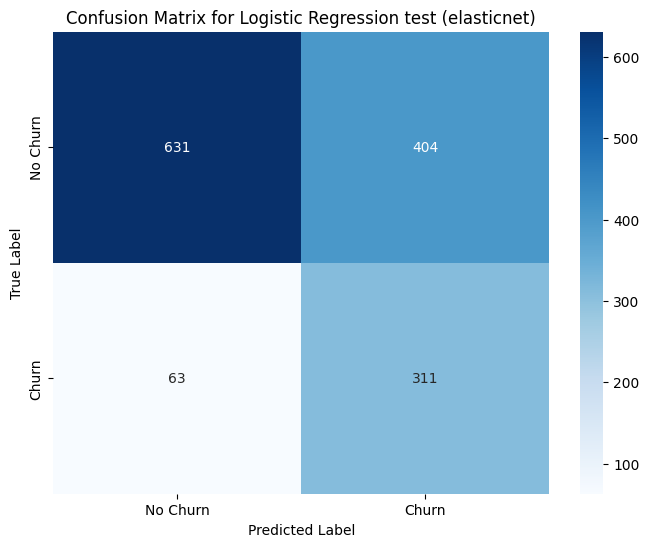

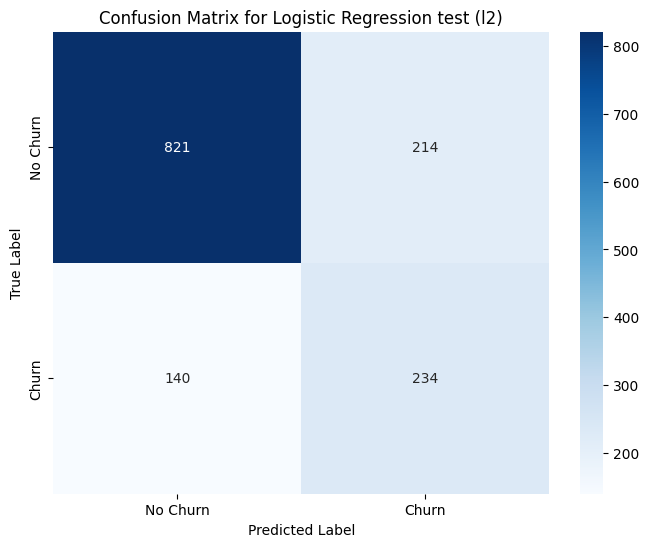

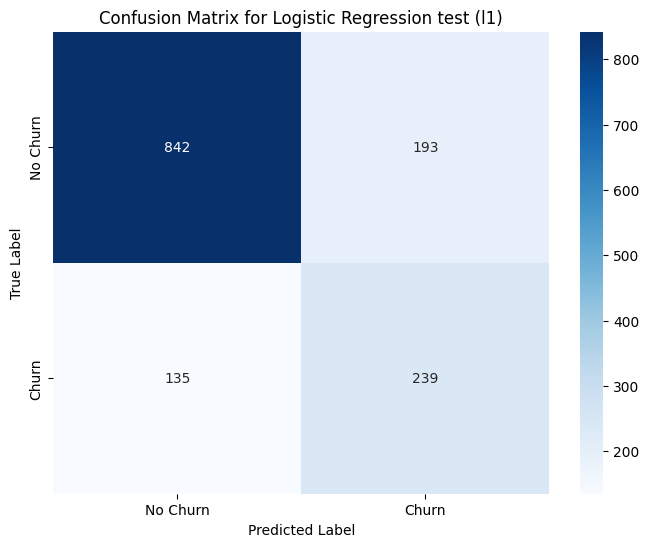

In [10]:

# Define file paths and experiment name
test_file = '/Users/anshugangwar/Desktop/Anshu/telecom-customer-churn-prediction/data/processed/test_processed.csv'
experiment_name = "Logistic_Regression"

# Execute the evaluation and registration process
evaluate_and_register_best_model(test_file, experiment_name)

In [5]:
all_runs = get_all_run_ids(experiment_name)

In [6]:
all_runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.eval_f1_no_churn,metrics.train_precision_no_churn,metrics.train_recall_no_churn,metrics.eval_accuracy,...,params.smote_random_state,params.test_size,params.random_state,tags.mlflow.source.git.commit,tags.mlflow.source.type,tags.mlflow.parentRunId,tags.mlflow.runName,tags.mlflow.user,tags.mlflow.log-model.history,tags.mlflow.source.name
0,b6d4d89a060049c69f7b19dd8ca4bbf0,1,FINISHED,mlflow-artifacts:/a62b228a9aaa43aa85015a9006f0...,2025-08-31 16:47:37.629000+00:00,2025-08-31 16:51:49.608000+00:00,0.729902,0.897292,0.616332,0.668559,...,42,0.2,42,b68555e584fef3f4b54bf4939dd03cada4518401,LOCAL,c193c0431dd24066b64eee5f6f446354,LogisticRegression_elasticnet,anshu57,"[{""run_id"": ""b6d4d89a060049c69f7b19dd8ca4bbf0""...",src/model/model_building.py
1,6b20fdf61eb64f4db1f27eb9cce10f3d,1,FINISHED,mlflow-artifacts:/a62b228a9aaa43aa85015a9006f0...,2025-08-31 16:47:17.616000+00:00,2025-08-31 16:52:10.361000+00:00,0.822645,0.869266,0.824112,0.748758,...,42,0.2,42,b68555e584fef3f4b54bf4939dd03cada4518401,LOCAL,c193c0431dd24066b64eee5f6f446354,LogisticRegression_l2,anshu57,"[{""run_id"": ""6b20fdf61eb64f4db1f27eb9cce10f3d""...",src/model/model_building.py
2,e2ffe7609ef54d0cb48ebd5c8e8fdbb9,1,FINISHED,mlflow-artifacts:/a62b228a9aaa43aa85015a9006f0...,2025-08-31 16:47:06.952000+00:00,2025-08-31 16:52:31.318000+00:00,0.836978,0.867230,0.842716,0.767211,...,42,0.2,42,b68555e584fef3f4b54bf4939dd03cada4518401,LOCAL,c193c0431dd24066b64eee5f6f446354,LogisticRegression_l1,anshu57,"[{""run_id"": ""e2ffe7609ef54d0cb48ebd5c8e8fdbb9""...",src/model/model_building.py


In [12]:
mlflow.log_artifact("/Users/anshugangwar/Desktop/Anshu/telecom-customer-churn-prediction/reports/test/confusion_matrix_testl2.png")

RestException: INVALID_PARAMETER_VALUE: Response: {'error_code': 'INVALID_PARAMETER_VALUE'}